# Fitting Anisotropic Power Diagrams to Grain Maps

In [165]:
# relevant libraries
import PyAPD
from pykeops.torch import LazyTensor
import copy
import torch
import matplotlib.pyplot as plt
import time
from matplotlib.ticker import FormatStrFormatter
import numpy as np

# typical setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

In [2]:
# helper functions

def rescaling(X, As, W,eps):
    At = As/eps
    Xt = 2.0*torch.einsum('bij,bj->bi', As, X)/eps
    Wt = (W - torch.einsum('bj,bj->b',X,eps*Xt/2.0))/eps
    return Xt, At, Wt

def inverse_rescaling(Xt, At, Wt,eps):
    As = eps*At
    X = (eps/2.0)*torch.linalg.solve(As,Xt)
    MV = torch.einsum('bij,bj->bi', As, X)
    W = eps*Wt + torch.einsum('bj,bj->b',MV,X)
    return X, As, W

def As_from_scalars(a11,a22,a12):
    return torch.stack([torch.stack([a11, a12],dim=1),
                            torch.stack([a12, a22], dim=1)],dim=2)

def X_from_scalar(x1,x2):
    return torch.stack([x1,x2],dim=1)

def from_theta_to_X_A_W(theta,N):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    a11 = theta[(2*N):(3*N)]
    a22 = theta[(3*N):(4*N)]
    a12 = theta[(4*N):(5*N)]
    Wt = theta[(5*N):(6*N)]
    At = As_from_scalars(a11,a22,a12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [3]:
def fitting_procedure(I, # grain map, indexed from 0
                      Y, # pixels
                      eps = 1e-3, # regularisation parameter
                      gtol_scalar = 1e-4,
                      approach = 3, # 1 is just fitting W, 2 is isotropic PD, 3 is APD
                      X_fix = None,
                      As_fix = None,
                      solver = 'bfgs',
                      defaultKwargs = None
                     ):
    if defaultKwargs is None:
        defaultKwargs = {'gtol': gtol_scalar,
                         'xtol': -1e-10,
                         'disp': 1,
                         'max_iter':500,
                         'line_search': 'none',
                         #'lr': 1e-2,
                        }
    y = LazyTensor(Y.view(1, len(Y), 2))
    N = (I.max()+1).item() # number of grains, inferred from the grain map
    # estimation based on moments
    normalisation = torch.bincount(I)
    vols = normalisation / Y.shape[0]
    X0 = torch.bincount(I,Y[:,0],minlength=N)/normalisation
    X1 = torch.bincount(I,Y[:,1],minlength=N)/normalisation
    X_est = torch.stack([X0,X1]).permute(1,0)
    i = 0
    YY_XX = Y[I==i] - X_est[i]
    tensor_prod = torch.einsum('bc,bd->bcd', YY_XX, YY_XX)
    tensor_prod_normalised = 16.0*tensor_prod.sum(dim=0) / normalisation[i]
    A_est = torch.linalg.inv(tensor_prod_normalised)
    As_est = A_est[None,:,:]
    for i in range(1,N):
        YY_XX = apd1.Y[I==i] - X_est[i]
        tensor_prod = torch.einsum('bc,bd->bcd', YY_XX, YY_XX)
        tensor_prod_normalised = 16.0*tensor_prod.sum(dim=0) / normalisation[i]
        A_est = torch.linalg.inv(tensor_prod_normalised)
        As_est = torch.cat((As_est,A_est[None,:,:]),dim=0)

    apd_est = PyAPD.apd_system(D = 2,
                               N=N,
                               X = X_est.contiguous(),
                               As = As_est.contiguous(),
                               target_masses = vols.contiguous(),
                               heuristic_W=True,
                               pixel_size_prefactor= 1)
    W_est = apd_est.W
    
    if approach == 1:
        if X_fix is None:
            X_fix = X_est
        if As_fix is None:
            As_fix = As_est
        
        def objective_function(X,A,W):
            dims = A.shape
            MV = torch.einsum('bij,bj->bi', torch.index_select(A,0,I), torch.index_select(X, 0, I) - Y)
            sD_ij = torch.einsum('bj,bj->b',MV,torch.index_select(X,0,I)-Y) - torch.index_select(W, 0, I)
            first_sum = (-sD_ij/eps).sum()
            
            W_t = W.view(dims[0],1,1)
            X_t = X.view(dims[0], 1, dims[1])
            a = LazyTensor(A.view(dims[0], 1, dims[1] * dims[2]))
            w = LazyTensor(W_t)
            x = LazyTensor(X_t)
            D_ij = ((y - x) | a.matvecmult(y - x)) - w
            second_sum = (-D_ij/eps).logsumexp(dim=0).sum(dim=0)
            return -eps*(first_sum - second_sum)
        # Defining the convex function to be optmised:
        fun_red = lambda W : objective_function(X_fix,As_fix, W)
        res = PyAPD.minimize_torch(fun_red, W_est, method=solver,
                             options=defaultKwargs)
        W_sol = res.x
        return X_est, As_est, W_sol, objective_function
    if approach == 2:
        #TODO
        def objective_function(X,A,W):
            return 0
        return X_est, As_est, W_est, objective_function
    if approach == 3:
        def objective_function(Xt,At,Wt):
            dims = At.shape
            MV = torch.einsum('bij,bj->bi', torch.index_select(At,0,I), Y)
            sD_ij = torch.einsum('bj,bj->b',MV,Y) - torch.index_select(Wt, 0, I) - torch.einsum('bi,bi->b',torch.index_select(Xt, 0, I),Y)
            first_sum = (-sD_ij).sum()
            Wt_t = Wt.view(dims[0],1,1)
            Xt_t = Xt.view(dims[0], 1, dims[1])
            at = LazyTensor(At.view(dims[0], 1, dims[1] * dims[2]))
            wt = LazyTensor(Wt_t)
            xt = LazyTensor(Xt_t)
            D_ij =  (y | at.matvecmult(y)) - wt - ((y*xt).sum(dim=2))
            second_sum = (-D_ij).logsumexp(dim=0).sum(dim=0)
            return -eps*(first_sum - second_sum)
        # Defining the convex function to be optmised:
        def fun(thetat):
            Xt, At, Wt = from_theta_to_X_A_W(thetat,N)
            return objective_function(Xt,At,Wt)
        Xt_initial, At_initial, Wt_initial = rescaling(apd_est.X, apd_est.As, apd_est.W,eps)
        thetat_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],At_initial[:,0,0],At_initial[:,1,1],At_initial[:,0,1],Wt_initial))
        res = PyAPD.minimize_torch(fun, thetat_initial, method=solver,
                             options=defaultKwargs)
        thetat_sol = res.x
        Xt_sol, At_sol, Wt_sol = from_theta_to_X_A_W(thetat_sol, N)
        X_sol, As_sol, W_sol = inverse_rescaling(Xt_sol, At_sol, Wt_sol,eps)
        return X_sol, As_sol, W_sol, objective_function

In [4]:
apd1 = PyAPD.apd_system(
    N = 20,
    seed = 5, # fix random seed
    pixel_size_prefactor = 2.0
)
apd1.check_optimality()
#apd1.find_optimal_W()
apd1.Lloyds_algorithm(K=10, verbosity_level = 0)
apd1.find_optimal_W()
#apd1.plot_apd()

Precision loss detected!
Percentage error =  162.65672302246094
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.4651099443435669
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.981643795967102
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.4651099443435669
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.981643795967102
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5679577589035034
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.826224684715271
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5679577589035034
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.826224684715271
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.826

In [5]:
# Save the data:
W_true = copy.deepcopy(apd1.W.contiguous())
As_true = copy.deepcopy(apd1.As.contiguous())
X_true = copy.deepcopy(apd1.X.contiguous())

# Save the grain map:
Y = copy.deepcopy(apd1.Y)
#Y_t = Y.view(1, len(Y), 2)
I = copy.deepcopy(apd1.assemble_apd())
#II = II + 1
#y = LazyTensor(Y_t)
print("We have ", len(Y), " pixels and ", (I.max()+1).item(), " grains.")

We have  7744  pixels and  20  grains.


In [26]:
eps_choice = 1e-3
gtol_choice = 1e-4

In [39]:
start=time.time()
X_sol, As_sol, W_sol, obj_fun = fitting_procedure(I, # grain map, indexed from 0
                                                  Y, # pixels
                                                  eps = eps_choice, # regularisation parameter
                                                  #gtol_scalar = 1e-5,
                                                  approach = 3, # 1 is just fitting W, 2 is isotropic PD, 3 is APD
                                                  X_fix = None,
                                                  As_fix = None,
                                                  solver = 'bfgs',
                                                  defaultKwargs = {'gtol': gtol_choice,
                                                                   'xtol': -1e-10,
                                                                   'disp': 1,
                                                                   'max_iter':2000,
                                                                   'line_search': 'none',
                                                                   #'lr': 1e-1,
                                                                  }
                                                 )
time_taken = time.time()-start

Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: 0.167000
         Iterations: 394
         Function evaluations: 395


In [ ]:
Xt_true, Ast_true, Wt_true = rescaling(X_true, As_true, W_true,eps_choice)

Xt_sol, Ast_sol, Wt_sol = rescaling(X_sol, As_sol, W_sol,eps_choice)

print(obj_fun(Xt_sol,Ast_sol,Wt_sol))

print(obj_fun(Xt_true,Ast_true,Wt_true))

In [32]:
apd_sol = PyAPD.apd_system(X = X_sol.contiguous(), As = As_sol.contiguous(), W = W_sol.contiguous())

Number of misassigned pixels:  tensor(38)
Proportion of misassigned pixels:  tensor(0.0049)
Time taken in seconds:  4.437504291534424


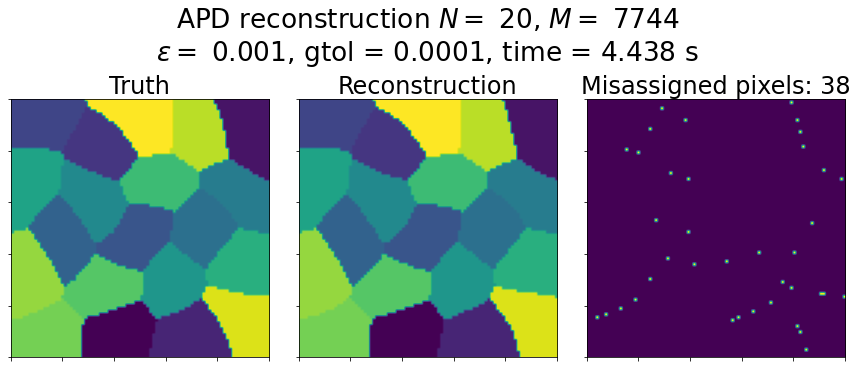

In [67]:
fs = 24
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
img_approx2 = copy.deepcopy(apd_sol.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])
print("Time taken in seconds: ",time_taken)

fig, ax = plt.subplots(1, 3,constrained_layout=True, figsize=(12, 5))
#fig.set_size_inches(20.5, 60.5, forward=True)


fig.suptitle(r'APD reconstruction $N = $ {}, $M = $ {}'.format(apd_sol.N,apd_sol.Y.shape[0]) + '\n' + 
             r'$\varepsilon =$ {0}, gtol = {1}, time = {2:.3f} s'.format(eps_choice,gtol_choice,time_taken), fontsize = 1.1*fs)
#fig.suptitle(r'APD reconstruction $N = $ {}, $M = $ {}, $\varepsilon =$ {}, gtol = {} '.format(
#    apd_sol.N,apd_sol.Y.shape[0],eps_choice,gtol_choice),fontsize = 1.1*fs)
#fig.tight_layout()
ax[0].imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[0].set_title('Truth',fontsize=fs)
ax[1].imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[1].set_title('Reconstruction',fontsize=fs)
#ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[2].imshow((torch.abs(img_true - img_approx2) > 0.5).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[2].set_title('Misassigned pixels: {}'.format(difff.item()),fontsize=fs)

for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])

In [140]:
### runtime test for differen Ns
eps_choice = 1e-3
gtol_choice = 1e-4
pixel_prefactor = 2

Ns = (5,10,15,20,25,30)
# create data:
apds = []
for N in Ns:
    apd1 = PyAPD.apd_system(
    N = N,
    seed = 5, # fix random seed
    pixel_size_prefactor = pixel_prefactor
    )
    apd1.check_optimality()
    #apd1.find_optimal_W()
    apd1.Lloyds_algorithm(K=10, verbosity_level = 0)
    apd1.find_optimal_W()
    apds.append(apd1)

Precision loss detected!
Percentage error =  90.34198760986328
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7233768701553345
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5679577589035034
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5679577589035034
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.4651099443435669
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.4651099443435669
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5679577589035034
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.30969083309173584
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.981643795967102
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.

In [141]:
timings = []
f_values = []
apds_sol = []
for i in range(len(Ns)):
    apd1 = apds[i]
    W_true = copy.deepcopy(apd1.W.contiguous())
    As_true = copy.deepcopy(apd1.As.contiguous())
    X_true = copy.deepcopy(apd1.X.contiguous())
    
    # Save the grain map:
    Y = copy.deepcopy(apd1.Y)
    #Y_t = Y.view(1, len(Y), 2)
    I = copy.deepcopy(apd1.assemble_apd())
    #II = II + 1
    #y = LazyTensor(Y_t)
    print("We have ", len(Y), " pixels and ", (I.max()+1).item(), " grains.")
    start=time.time()
    X_sol, As_sol, W_sol, obj_fun = fitting_procedure(I, # grain map, indexed from 0
                                                      Y, # pixels
                                                      eps = eps_choice, # regularisation parameter
                                                      #gtol_scalar = 1e-5,
                                                      approach = 3, # 1 is just fitting W, 2 is isotropic PD, 3 is APD
                                                      X_fix = None,
                                                      As_fix = None,
                                                      solver = 'bfgs',
                                                      defaultKwargs = {'gtol': gtol_choice,
                                                                       'xtol': -1e-10,
                                                                       'disp': 1,
                                                                       'max_iter':2000,
                                                                       'line_search': 'none',
                                                                       #'lr': 1e-1,
                                                                      }
                                                     )
    time_taken = time.time()-start
    Xt_true, Ast_true, Wt_true = rescaling(X_true, As_true, W_true,eps_choice)
    Xt_sol, Ast_sol, Wt_sol = rescaling(X_sol, As_sol, W_sol,eps_choice)

    timings.append(time_taken)
    f_values.append(obj_fun(Xt_sol,Ast_sol,Wt_sol) - obj_fun(Xt_true,Ast_true,Wt_true))
    apd_sol = PyAPD.apd_system(X = X_sol.contiguous(),
                               As = As_sol.contiguous(),
                               W = W_sol.contiguous(),
                               pixel_size_prefactor = pixel_prefactor
                              )
    apds_sol.append(apd_sol)

We have  1936  pixels and  5  grains.
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: 0.000625
         Iterations: 103
         Function evaluations: 104
We have  3844  pixels and  10  grains.
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: 0.229767
         Iterations: 191
         Function evaluations: 192
We have  5776  pixels and  15  grains.
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: 0.300438
         Iterations: 298
         Function evaluations: 299
We have  7744  pixels and  20  grains.
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: 0.167000
         Iterations: 394
         Function evaluations: 395
We have  10000  pixels and  25  grains.
Optimality condition successfully overwritten.
Optimizati

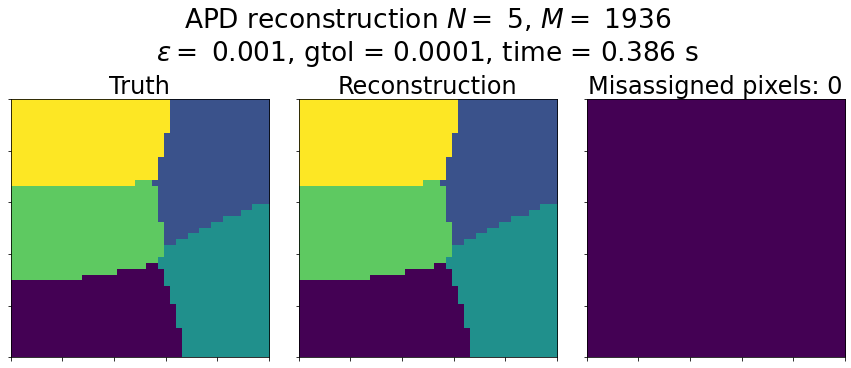

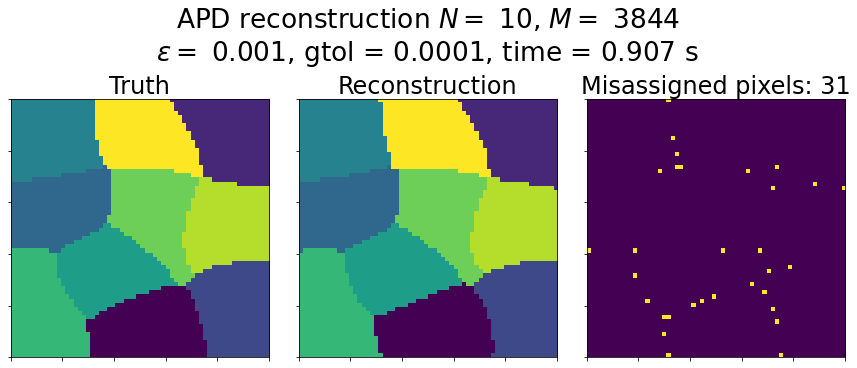

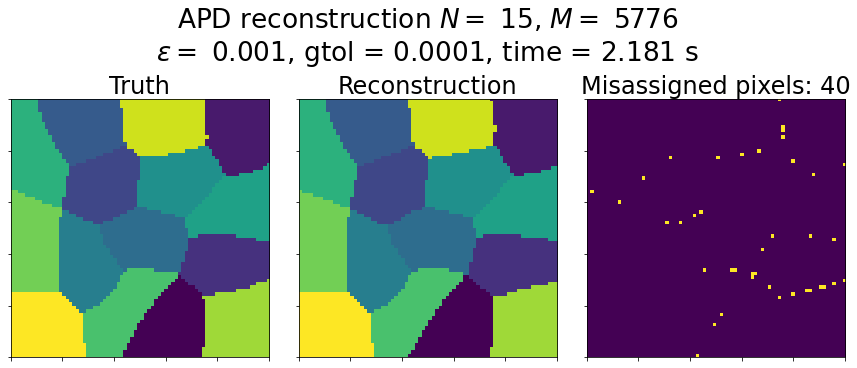

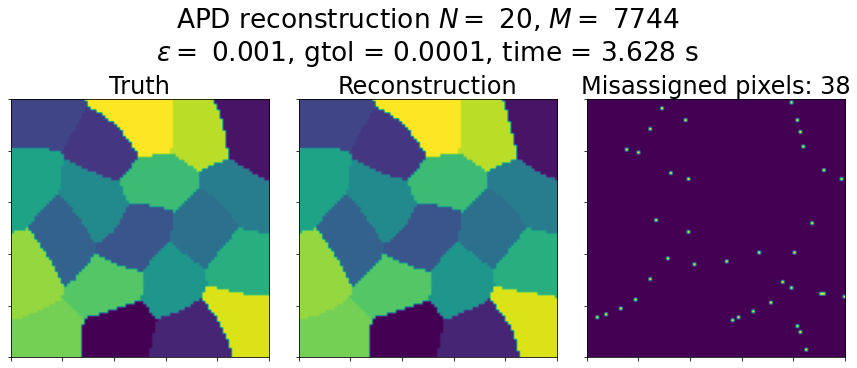

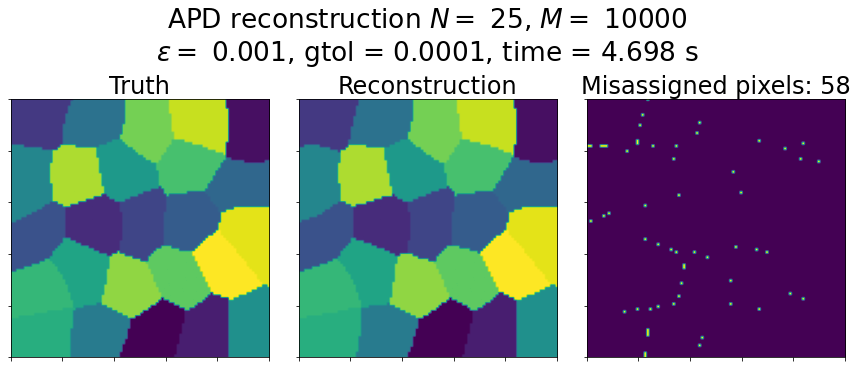

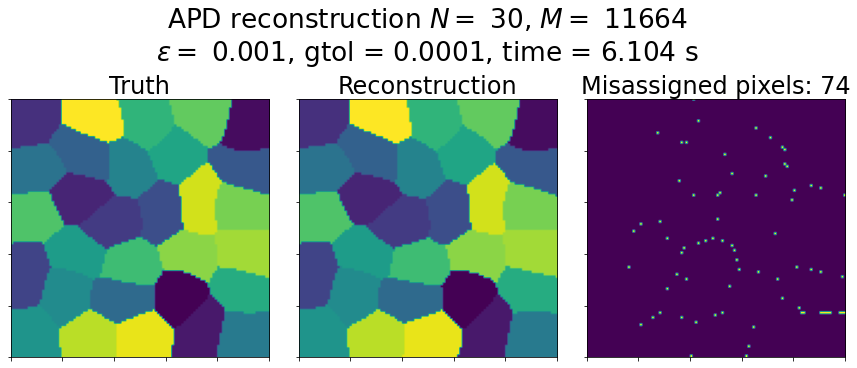

In [142]:
fs = 24
for i in range(len(Ns)):
    apd1 = apds[i]
    img_true = copy.deepcopy(apd1.assemble_apd())
    apd_sol = apds_sol[i]
    img_approx = copy.deepcopy(apd_sol.assemble_apd())
    
    difff = sum(torch.abs(img_true - img_approx) > 0.5)
    
    #print("Number of misassigned pixels: ",difff)
    #print("Proportion of misassigned pixels: ",difff / img_true.shape[0])
    #print("Time taken in seconds: ",timings[i])
    
    fig, ax = plt.subplots(1, 3,constrained_layout=True, figsize=(12, 5))
    #fig.set_size_inches(20.5, 60.5, forward=True)
    
    
    fig.suptitle(r'APD reconstruction $N = $ {}, $M = $ {}'.format(apd_sol.N,apd_sol.Y.shape[0]) + '\n' + 
                 r'$\varepsilon =$ {0}, gtol = {1}, time = {2:.3f} s'.format(eps_choice,gtol_choice,timings[i]), fontsize = 1.1*fs)
    #fig.suptitle(r'APD reconstruction $N = $ {}, $M = $ {}, $\varepsilon =$ {}, gtol = {} '.format(
    #    apd_sol.N,apd_sol.Y.shape[0],eps_choice,gtol_choice),fontsize = 1.1*fs)
    #fig.tight_layout()
    ax[0].imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
    ax[0].set_title('Truth',fontsize=fs)
    ax[1].imshow(img_approx.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
    ax[1].set_title('Reconstruction',fontsize=fs)
    #ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
    ax[2].imshow((torch.abs(img_true - img_approx) > 0.5).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
    ax[2].set_title('Misassigned pixels: {}'.format(difff.item()),fontsize=fs)
    
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])

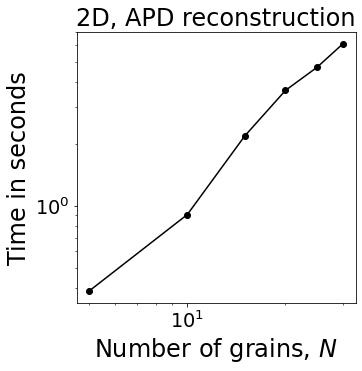

In [145]:
fig, ax1 = plt.subplots(1,1,figsize=(5, 5))
ax1.plot(Ns,timings,'ko-')
ax1.xaxis.label.set_size(fs)
ax1.yaxis.label.set_size(fs)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fs*0.8) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fs*0.8) 
#ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0),
#            ncol=1, fancybox=True, shadow=True, fontsize="28")
ax1.set_xlabel(r'Number of grains, $N$')
ax1.set_ylabel("Time in seconds")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title(r'2D, APD reconstruction')
ax1.title.set_size(fs)

#ax1.tick_params(which='minor', length=4, color='r')
ax1.set_xticklabels(minor=True, labels = [])
None
#ax1.xaxis.set_minor_formatter(FormatStrFormatter())

## Reconstructing just $W$

In [69]:
eps_choice = 1e-3
gtol_choice = 1e-3

In [70]:
start=time.time()
_, _, W_sol_red, obj_fun_red = fitting_procedure(I, # grain map, indexed from 0
                                             Y, # pixels
                                             eps = eps_choice, # regularisation parameter
                                             #gtol_scalar = 1e-3,
                                             approach = 1, # 1 is just fitting W, 2 is isotropic PD, 3 is APD
                                             X_fix = X_true,
                                             As_fix = As_true,
                                             solver = 'bfgs',
                                             defaultKwargs = {'gtol': gtol_choice,
                                                              'xtol': -1e-10,
                                                              'disp': 1,
                                                              'max_iter':2000,
                                                              'line_search': 'none',
                                                             #'lr': 1e-2,
                                                             }
                                             )
time_taken_red = time.time()-start

Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: 0.189500
         Iterations: 20
         Function evaluations: 21


Number of misassigned pixels:  tensor(10)
Proportion of misassigned pixels:  tensor(0.0013)
Time taken in seconds:  0.19372057914733887


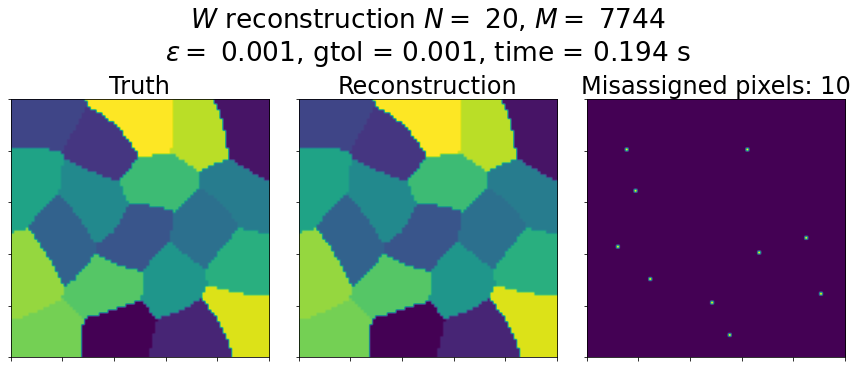

In [72]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_sol_red)
img_approx = copy.deepcopy(apd1.assemble_apd())

difff = sum(torch.abs(img_true - img_approx) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])
print("Time taken in seconds: ",time_taken_red)

apd1.set_W(W = W_true) # reset weights to the optimum

#fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig, ax = plt.subplots(1, 3,constrained_layout=True, figsize=(12, 5))
#fig.set_size_inches(10.5, 30.5, forward=True)
#fig.suptitle(r'$W$ reconstruction, $N = $ {}, $M = $ {}, $\varepsilon =$ {}, gtol = {}  '.format(apd_sol.N,apd_sol.Y.shape[0],eps_choice, gtol_choice),fontsize = 1.1*fs)
fig.suptitle(r'$W$ reconstruction $N = $ {}, $M = $ {}'.format(apd_sol.N,apd_sol.Y.shape[0]) + '\n' + 
             r'$\varepsilon =$ {0}, gtol = {1}, time = {2:.3f} s'.format(eps_choice,gtol_choice,time_taken_red), fontsize = 1.1*fs)

ax[0].imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[0].set_title('Truth',fontsize = fs)
ax[1].imshow(img_approx.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[1].set_title('Reconstruction', fontsize = fs)
ax[2].imshow((torch.abs(img_true - img_approx) > 0.5).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[2].set_title('Misassigned pixels: {}'.format(difff),fontsize = fs)

for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])

In [73]:
obj_fun_red(X_true,As_true,W_sol_red)

tensor([0.1895])

In [74]:
obj_fun_red(X_true,As_true,W_true)

tensor([0.1914])

In [149]:
### runtime test for differen Ns
eps_choice = 5e-4
gtol_choice = 1e-3
pixel_prefactor = 2

Ns = (5,10,15,20,25,30)
# create data:
apds = []
for N in Ns:
    apd1 = PyAPD.apd_system(
    N = N,
    seed = 5, # fix random seed
    pixel_size_prefactor = pixel_prefactor
    )
    apd1.check_optimality()
    #apd1.find_optimal_W()
    apd1.Lloyds_algorithm(K=10, verbosity_level = 0)
    apd1.find_optimal_W()
    apds.append(apd1)

Precision loss detected!
Percentage error =  90.34198760986328
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7233768701553345
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5679577589035034
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5679577589035034
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.4651099443435669
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.4651099443435669
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5679577589035034
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.30969083309173584
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.981643795967102
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.

In [153]:
timings = []
f_values = []
apds_sol = []
for i in range(len(Ns)):
    apd1 = apds[i]
    W_true = copy.deepcopy(apd1.W.contiguous())
    As_true = copy.deepcopy(apd1.As.contiguous())
    X_true = copy.deepcopy(apd1.X.contiguous())
    
    # Save the grain map:
    Y = copy.deepcopy(apd1.Y)
    #Y_t = Y.view(1, len(Y), 2)
    I = copy.deepcopy(apd1.assemble_apd())
    #II = II + 1
    #y = LazyTensor(Y_t)
    print("We have ", len(Y), " pixels and ", (I.max()+1).item(), " grains.")
    start=time.time()
    _, _, W_sol_red, obj_fun_red = fitting_procedure(I, # grain map, indexed from 0
                                                 Y, # pixels
                                                 eps = eps_choice, # regularisation parameter
                                                 #gtol_scalar = 1e-3,
                                                 approach = 1, # 1 is just fitting W, 2 is isotropic PD, 3 is APD
                                                 X_fix = X_true,
                                                 As_fix = As_true,
                                                 solver = 'bfgs',
                                                 defaultKwargs = {'gtol': gtol_choice,
                                                                  'xtol': -1e-10,
                                                                  'disp': 1,
                                                                  'max_iter':2000,
                                                                  'line_search': 'none',
                                                                  'lr': 5e-1,
                                                                 }
                                                 )
    time_taken_red = time.time()-start
    timings.append(time_taken_red)
    f_values.append(obj_fun_red(X_true,As_true,W_sol_red)-
                    obj_fun_red(X_true,As_true,W_true))
    apd_sol = PyAPD.apd_system(X = X_true,
                               As = As_true,
                               W = W_sol_red.contiguous(),
                               pixel_size_prefactor = pixel_prefactor
                              )
    apds_sol.append(apd_sol)

We have  1936  pixels and  5  grains.
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: 0.001438
         Iterations: 20
         Function evaluations: 21
We have  3844  pixels and  10  grains.
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: 0.011313
         Iterations: 31
         Function evaluations: 32
We have  5776  pixels and  15  grains.
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: 0.025375
         Iterations: 30
         Function evaluations: 31
We have  7744  pixels and  20  grains.
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: 0.046625
         Iterations: 31
         Function evaluations: 32
We have  10000  pixels and  25  grains.
Optimality condition successfully overwritten.
Optimization termi

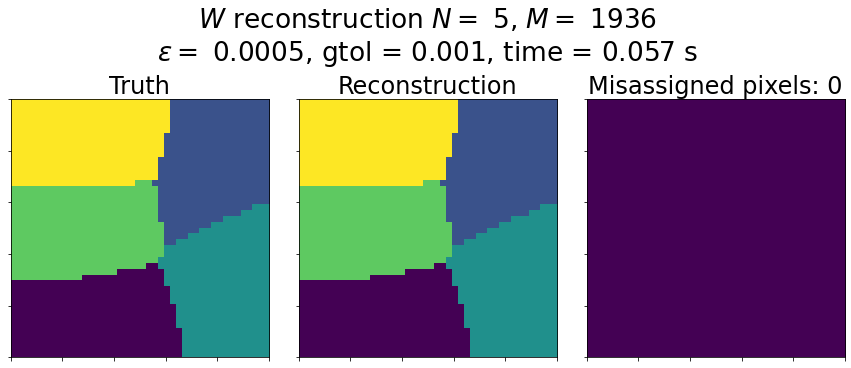

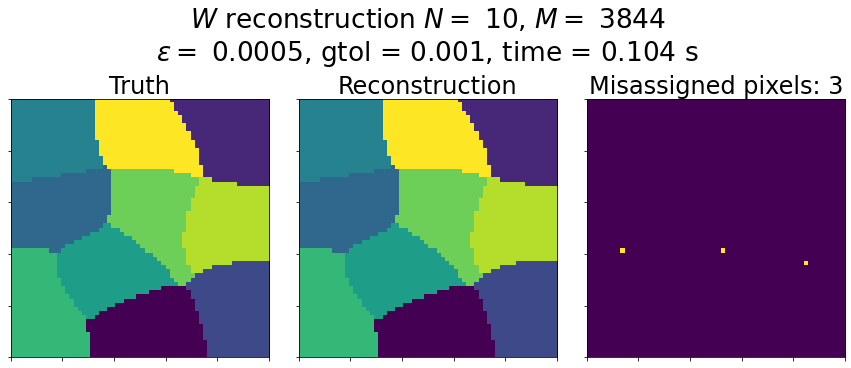

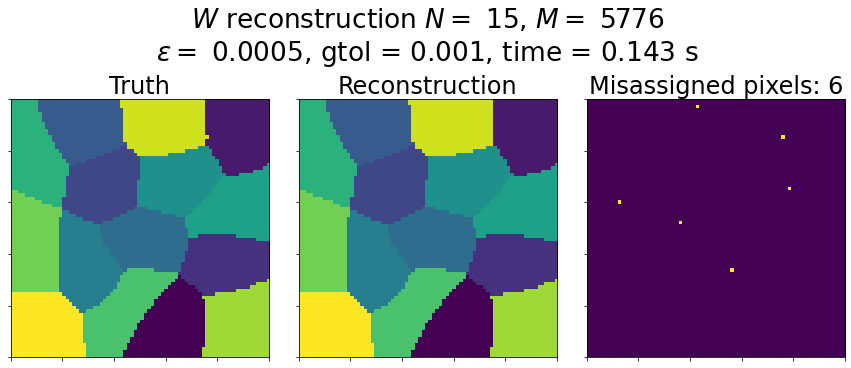

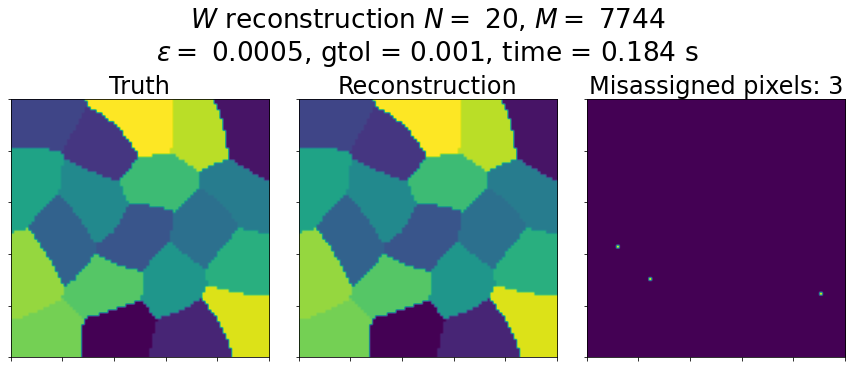

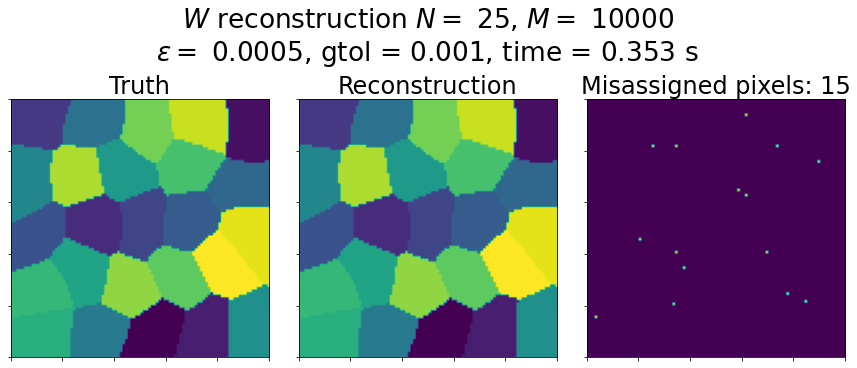

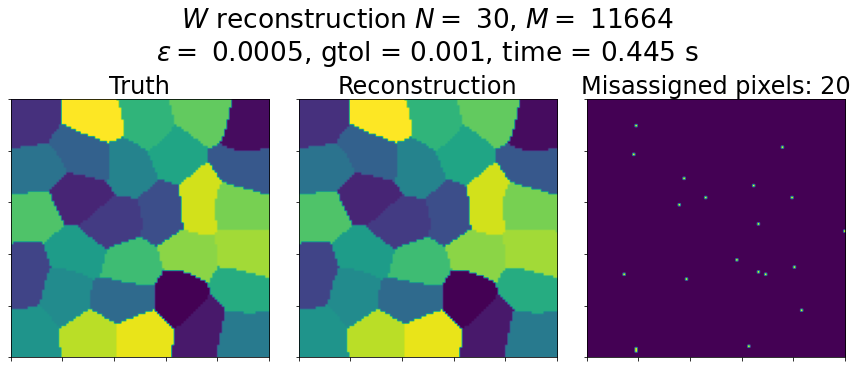

In [154]:
fs = 24
for i in range(len(Ns)):
    apd1 = apds[i]
    img_true = copy.deepcopy(apd1.assemble_apd())
    apd_sol = apds_sol[i]
    img_approx = copy.deepcopy(apd_sol.assemble_apd())
    
    difff = sum(torch.abs(img_true - img_approx) > 0.5)
    
    #print("Number of misassigned pixels: ",difff)
    #print("Proportion of misassigned pixels: ",difff / img_true.shape[0])
    #print("Time taken in seconds: ",timings[i])
    
    fig, ax = plt.subplots(1, 3,constrained_layout=True, figsize=(12, 5))
    #fig.set_size_inches(20.5, 60.5, forward=True)
    
    
    fig.suptitle(r'$W$ reconstruction $N = $ {}, $M = $ {}'.format(apd_sol.N,apd_sol.Y.shape[0]) + '\n' + 
                 r'$\varepsilon =$ {0}, gtol = {1}, time = {2:.3f} s'.format(eps_choice,gtol_choice,timings[i]), fontsize = 1.1*fs)
    #fig.suptitle(r'APD reconstruction $N = $ {}, $M = $ {}, $\varepsilon =$ {}, gtol = {} '.format(
    #    apd_sol.N,apd_sol.Y.shape[0],eps_choice,gtol_choice),fontsize = 1.1*fs)
    #fig.tight_layout()
    ax[0].imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
    ax[0].set_title('Truth',fontsize=fs)
    ax[1].imshow(img_approx.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
    ax[1].set_title('Reconstruction',fontsize=fs)
    #ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
    ax[2].imshow((torch.abs(img_true - img_approx) > 0.5).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
    ax[2].set_title('Misassigned pixels: {}'.format(difff.item()),fontsize=fs)
    
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])

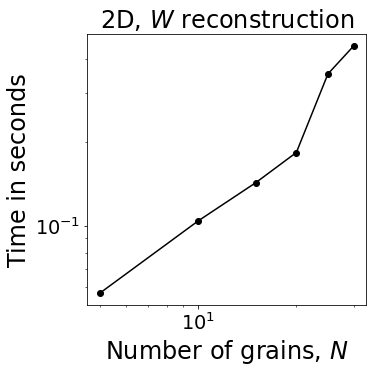

In [157]:
fig, ax1 = plt.subplots(1,1,figsize=(5, 5))
ax1.plot(Ns,timings,'ko-')
ax1.xaxis.label.set_size(fs)
ax1.yaxis.label.set_size(fs)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fs*0.8) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fs*0.8) 
#ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0),
#            ncol=1, fancybox=True, shadow=True, fontsize="28")
ax1.set_xlabel(r'Number of grains, $N$')
ax1.set_ylabel("Time in seconds")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title(r'2D, $W$ reconstruction')
ax1.title.set_size(fs)

#ax1.tick_params(which='minor', length=4, color='r')
ax1.set_xticklabels(minor=True, labels = [])
ax1.set_yticklabels(minor=True, labels = [])
None
#ax1.xaxis.set_minor_formatter(FormatStrFormatter())

## EBSD data example

In [158]:
pwd()

'/home/mb/MEGAsync/academic_work/projects/geometric_model_polycrystals/code/PyAPD/notebooks/extensions/grain_maps_fitting'

In [159]:
file = "../../../data/2D_Tata_Steel_paper_example/sample_lc_steel_grain_file_final.txt"
seed_id = (0,1)
volumes_id = (5)
orientation_id = (2,3,4)

X, A, TV, EBSD = PyAPD.load_setup_from_EBSD_data_2D(file = file,
                                             seed_id = seed_id,
                                             volumes_id = volumes_id,
                                             orientation_id = orientation_id,
                                             normalise_matrices = True,
                                             angle_in_degrees = False,
                                             device = device,
                                             dt = dt)
X = X.to(device,dtype=dt).contiguous()
A = A.to(device,dtype=dt).contiguous()
TV = TV.to(device,dtype=dt).contiguous()
N, D = X.shape

# Manually enter the correct domain size:
dom_x = [-999.02675,0.49975]
dom_y = [-901.0003,0.5003]
domain = torch.tensor([dom_x,dom_y])

# Compute total area and show largest and smallest grain:
total_area = TV.sum()
print("Largest grain: ", torch.max(TV).cpu().numpy(),
      "Smallest grain: ",torch.min(TV).cpu().numpy()
     )

Largest grain:  2073.79661128761 Smallest grain:  11.000898081641


In [160]:
# Construct an APD system:
apd1 = PyAPD.apd_system(D=2,
                  domain = domain,
                  X = X,
                  As = A,
                  heuristic_W = True, # the default set of weights is the heuristic guess
                  target_masses = TV/total_area,
                  dt = torch.float64,
                  device = device,
                  pixel_size_prefactor = 1.0,
                  error_tolerance = 0.05
                  )

In [161]:
W_heuristic = copy.deepcopy(apd1.W.contiguous())

In [ ]:
apd1.check_optimality()

In [ ]:
#apd1.find_optimal_W()
#apd1.check_optimality()
#W_OT = copy.deepcopy(apd1.W.contiguous())

In [162]:
# Create a set of pixels to match the pixelated EBSD data:
i = 0
grid_x = torch.linspace(apd1.domain[i,0] + 0.9995/2, apd1.domain[i,1] - 0.9995/2, 1000)

i = 1
grid_y = torch.linspace(apd1.domain[i,0] + 1.0006/2, apd1.domain[i,1] - 1.0006/2, 901)

mesh1 = torch.meshgrid((grid_x,grid_y), indexing="ij") if apd1.D == 2 else torch.meshgrid((grid_x,grid_y,grid_z), indexing="ij")
pixels1 = torch.stack(mesh1, dim=-1).to(device=apd1.device,dtype=apd1.dt)
pixels1b = pixels1.reshape(-1, apd1.D)
pixels = pixels1b
PS = torch.ones(pixels.shape[0])

In [163]:
# Pass it to the apd system:
apd1.Y = pixels.to(device=apd1.device, dtype=apd1.dt).contiguous()
apd1.PS = PS.to(device=apd1.device, dtype=apd1.dt).contiguous()
apd1.y = LazyTensor(apd1.Y.view(1,apd1.Y.shape[0],apd1.D))

In [ ]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_OT)
img_optimal = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_heuristic)
img_heuristic = copy.deepcopy(apd1.assemble_apd())

diff_opt_heu = sum(torch.abs(img_heuristic - img_optimal) > 0.5)

diff_opt_heu / img_optimal.shape[0]

In [166]:
# Load EBSD pixelated data: positions of pixels and grain assignment (from MTEX):
file = "../../../data/2D_Tata_Steel_paper_example/grainIDs_final.txt"
EBSD_pixel_data = torch.from_numpy(np.loadtxt(file)).to(device=apd1.device, dtype=apd1.dt)

In [172]:
Y = EBSD_pixel_data[:,0:2].contiguous()
#Y_t = 
I = EBSD_pixel_data[:,2].int() - 1 # grain map
#y = LazyTensor(Y.view(1, len(Y), 2))

In [171]:
# Save the data:
#W_true = copy.deepcopy(apd1.W.contiguous())
As_true = copy.deepcopy(apd1.As.contiguous())
X_true = copy.deepcopy(apd1.X.contiguous())

print("We have ", len(Y), " pixels and ", apd1.N, " grains.")

We have  896361  pixels and  4587  grains.


## Fitting an APD

In [ ]:
eps_choice = 1e-3
gtol_choice = 1e-4

In [ ]:
start=time.time()
X_sol, As_sol, W_sol, obj_fun = fitting_procedure(I, # grain map, indexed from 0
                                                  Y, # pixels
                                                  eps = eps_choice, # regularisation parameter
                                                  #gtol_scalar = 1e-5,
                                                  approach = 3, # 1 is just fitting W, 2 is isotropic PD, 3 is APD
                                                  X_fix = None,
                                                  As_fix = None,
                                                  solver = 'bfgs',
                                                  defaultKwargs = {'gtol': gtol_choice,
                                                                   'xtol': -1e-10,
                                                                   'disp': 1,
                                                                   'max_iter':2000,
                                                                   'line_search': 'none',
                                                                   #'lr': 1e-1,
                                                                  }
                                                 )
time_taken = time.time()-start

In [ ]:
Xt_true, Ast_true, Wt_heuristic = rescaling(X_true, As_true, W_heuristic,eps_choice)

Xt_sol, Ast_sol, Wt_sol = rescaling(X_sol, As_sol, W_sol,eps_choice)

print(obj_fun(Xt_sol,Ast_sol,Wt_sol))

print(obj_fun(Xt_true,Ast_true,Wt_heuristic))

In [ ]:
apd_sol = PyAPD.apd_system(X = X_sol.contiguous(), As = As_sol.contiguous(), W = W_sol.contiguous())

In [ ]:
fs = 24
apd1.set_W(W = W_heuristic)
img_true = copy.deepcopy(apd1.assemble_apd())
img_approx2 = copy.deepcopy(apd_sol.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])
print("Time taken in seconds: ",time_taken)

fig, ax = plt.subplots(1, 3,constrained_layout=True, figsize=(12, 5))
#fig.set_size_inches(20.5, 60.5, forward=True)


fig.suptitle(r'APD reconstruction $N = $ {}, $M = $ {}'.format(apd_sol.N,apd_sol.Y.shape[0]) + '\n' + 
             r'$\varepsilon =$ {0}, gtol = {1}, time = {2:.3f} s'.format(eps_choice,gtol_choice,time_taken), fontsize = 1.1*fs)
#fig.suptitle(r'APD reconstruction $N = $ {}, $M = $ {}, $\varepsilon =$ {}, gtol = {} '.format(
#    apd_sol.N,apd_sol.Y.shape[0],eps_choice,gtol_choice),fontsize = 1.1*fs)
#fig.tight_layout()
ax[0].imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[0].set_title('Truth',fontsize=fs)
ax[1].imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[1].set_title('Reconstruction',fontsize=fs)
#ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[2].imshow((torch.abs(img_true - img_approx2) > 0.5).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[2].set_title('Misassigned pixels: {}'.format(difff.item()),fontsize=fs)

for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])

## Fitting just $W$

In [ ]:
eps_choice = 1e-3
gtol_choice = 1e-3

In [ ]:
start=time.time()
_, _, W_sol_red, obj_fun_red = fitting_procedure(I, # grain map, indexed from 0
                                             Y, # pixels
                                             eps = eps_choice, # regularisation parameter
                                             #gtol_scalar = 1e-3,
                                             approach = 1, # 1 is just fitting W, 2 is isotropic PD, 3 is APD
                                             X_fix = X_true,
                                             As_fix = As_true,
                                             solver = 'bfgs',
                                             defaultKwargs = {'gtol': gtol_choice,
                                                              'xtol': -1e-10,
                                                              'disp': 1,
                                                              'max_iter':2000,
                                                              'line_search': 'none',
                                                             #'lr': 1e-2,
                                                             }
                                             )
time_taken_red = time.time()-start

In [ ]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_heuristic)
img_true = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_sol_red)
img_approx = copy.deepcopy(apd1.assemble_apd())

difff = sum(torch.abs(img_true - img_approx) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])
print("Time taken in seconds: ",time_taken_red)

apd1.set_W(W = W_true) # reset weights to the optimum

#fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig, ax = plt.subplots(1, 3,constrained_layout=True, figsize=(12, 5))
#fig.set_size_inches(10.5, 30.5, forward=True)
#fig.suptitle(r'$W$ reconstruction, $N = $ {}, $M = $ {}, $\varepsilon =$ {}, gtol = {}  '.format(apd_sol.N,apd_sol.Y.shape[0],eps_choice, gtol_choice),fontsize = 1.1*fs)
fig.suptitle(r'$W$ reconstruction $N = $ {}, $M = $ {}'.format(apd_sol.N,apd_sol.Y.shape[0]) + '\n' + 
             r'$\varepsilon =$ {0}, gtol = {1}, time = {2:.3f} s'.format(eps_choice,gtol_choice,time_taken_red), fontsize = 1.1*fs)

ax[0].imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[0].set_title('Truth',fontsize = fs)
ax[1].imshow(img_approx.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[1].set_title('Reconstruction', fontsize = fs)
ax[2].imshow((torch.abs(img_true - img_approx) > 0.5).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax[2].set_title('Misassigned pixels: {}'.format(difff),fontsize = fs)

for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])

In [ ]:
obj_fun_red(X_true,As_true,W_sol_red)

In [ ]:
obj_fun_red(X_true,As_true,W_heuristic)